# Read LLMs responses, compute accuracy and confidence intervals

In [1]:
import tabmemcheck

import yaml
from pathlib import Path

from sklearn.model_selection import train_test_split

import statutils
import numpy as np
import os

In [2]:
# datasets
with open("datasets.yaml") as file:
    datasets = yaml.load(file, Loader=yaml.FullLoader)["datasets"]

versions = ["original", "perturbed", "task", "statistical"]

In [3]:
# the experiments
experiments = {}
for csv_file, yaml_file in datasets:
    for version in versions:
        exp_basename = Path(yaml_file).stem
        for seed in range(10):
            experiments[f"{exp_basename}-{version}-{seed}"] = {
                "csv-file": csv_file,
                "yaml-file": yaml_file,
                "transform": version,
                "system-prompt": exp_basename,
                "seed": seed,
        }

In [4]:
chatlogs_path = 'chatlogs-llama3-70b'

for exp_name, experiment in experiments.items():
    print("Experiment: ", exp_name)
    seed = seed = experiment["seed"]

    # check if the chatlogs folder exists
    chatlogs_folder = Path(os.path.join(chatlogs_path, exp_name))
    if not chatlogs_folder.exists():
        continue

    # the dataset
    df = tabmemcheck.datasets.load_dataset(
        experiment["csv-file"],
        experiment["yaml-file"],
        experiment["transform"],
        seed=seed,
    )

    feature_names, target_name = df.columns.tolist()[:-1], df.columns.tolist()[-1]

    # train / test split
    X_data, y_data = df[feature_names].values, df[target_name].values
    if X_data.shape[0] > 1300:
        X_train, X_test, y_train, y_test = train_test_split(
            X_data, y_data, test_size=0.2, random_state=42
        )
    else:
        X_train, y_train = X_data, y_data

    messages, responses = tabmemcheck.read_chatlog(exp_name, chatlogs_path)
    print(len(messages), len(responses))
    print(messages[0])

    # save the predictions
    experiments[exp_name]["y_true"] = y_train[:1000]
    experiments[exp_name]["gpt-3.5"] = responses

Experiment:  iris-original-0
150 150
[{'role': 'system', 'content': 'You are a classification assistant who is an expert in tabular data, data science, and machine learning. You help to make predictions on the Iris dataset. Your task is to predict the type of a flower. You respond with the type of the flower. Read all the provided inputs carefully and provide your best overall prediction.'}, {'role': 'user', 'content': 'IF sepal_length = 6.7, sepal_width = 3.1, petal_length = 4.4, petal_width = 1.4, THEN species ='}, {'role': 'assistant', 'content': 'Iris-versicolor'}, {'role': 'user', 'content': 'IF sepal_length = 6.0, sepal_width = 2.2, petal_length = 4.0, petal_width = 1.0, THEN species ='}, {'role': 'assistant', 'content': 'Iris-versicolor'}, {'role': 'user', 'content': 'IF sepal_length = 7.9, sepal_width = 3.8, petal_length = 6.4, petal_width = 2.0, THEN species ='}, {'role': 'assistant', 'content': 'Iris-virginica'}, {'role': 'user', 'content': 'IF sepal_length = 5.4, sepal_width

### the number of different seeds (3 for gpt-3.5, 1 for gpt-4)

In [5]:
num_seeds = 1

## ACS Income

In [6]:
exp_name = "acs-income"
for version in versions:
    print(experiments[f'{exp_name}-{version}-0']["gpt-3.5"][:10])
    print(experiments[f'{exp_name}-{version}-0']["y_true"][:10])

['More than $50,000 per year.', 'Less than $50,000 per year.', 'More than $50,000 per year.', 'More than $50,000 per year.', 'Less than $50,000 per year.', 'Less than $50,000 per year.', 'More than $50,000 per year.', 'Less than $50,000 per year.', 'More than $50,000 per year.', 'More than $50,000 per year.']
['Less than $50,000 per year.' 'Less than $50,000 per year.'
 'More than $50,000 per year.' 'Less than $50,000 per year.'
 'Less than $50,000 per year.' 'Less than $50,000 per year.'
 'More than $50,000 per year.' 'Less than $50,000 per year.'
 'More than $50,000 per year.' 'More than $50,000 per year.']
['More than $50,000 per year.', 'Less than $50,000 per year.', 'More than $50,000 per year.', 'More than $50,000 per year.', 'Less than $50,000 per year.', 'Less than $50,000 per year.', 'More than $50,000 per year.', 'Less than $50,000 per year.', 'More than $50,000 per year.', 'More than $50,000 per year.']
['Less than $50,000 per year.' 'Less than $50,000 per year.'
 'More than

In [7]:
exp_name = "acs-income"

for seed in range(num_seeds):
    for version in ['original', 'perturbed', 'task']:
        experiments[f'{exp_name}-{version}-{seed}']["gpt-3.5"] = [0 if r is None or "Less" in r else 1 for r in experiments[f'{exp_name}-{version}-{seed}']["gpt-3.5"]]
        experiments[f'{exp_name}-{version}-{seed}']["y_true"] = [0 if r is None or "Less" in r else 1 for r in experiments[f'{exp_name}-{version}-{seed}']["y_true"]]
    experiments[f'{exp_name}-statistical-{seed}']["gpt-3.5"] = [int(x) if x.isdigit() else 0 for x in experiments[f'{exp_name}-statistical-{seed}']["gpt-3.5"]]


In [8]:
exp_name = 'acs-income'
for version in versions:
    print(exp_name + '-' + version)
    mean_acc = 0
    for seed in range(num_seeds):
        y_true, y_pred = (
            experiments[exp_name + f'-{version}-{seed}']["y_true"],
            experiments[exp_name + f'-{version}-{seed}']["gpt-3.5"],
        )
        acc, _ = statutils.accuracy(np.array(y_true), y_pred)
        mean_acc += acc
    print(mean_acc / num_seeds)
    print("-" * 80)

acs-income-original
Accuracy: 0.78, 95%-Confidence Interval: (0.75, 0.80), Standard error: 0.01
0.778
--------------------------------------------------------------------------------
acs-income-perturbed
Accuracy: 0.78, 95%-Confidence Interval: (0.75, 0.80), Standard error: 0.01
0.776
--------------------------------------------------------------------------------
acs-income-task
Accuracy: 0.77, 95%-Confidence Interval: (0.74, 0.79), Standard error: 0.01
0.767
--------------------------------------------------------------------------------
acs-income-statistical
Accuracy: 0.59, 95%-Confidence Interval: (0.56, 0.62), Standard error: 0.02
0.588
--------------------------------------------------------------------------------


## ACS Travel

In [9]:
exp_name = "acs-travel"
for version in versions:
    print(experiments[f'{exp_name}-{version}-0']["gpt-3.5"][990:])
    print(experiments[f'{exp_name}-{version}-0']["y_true"][990:])

['More than 20 minutes', 'Less than 20 minutes', 'Less than 20 minutes', 'More than 20 minutes', 'Less than 20 minutes', 'Less than 20 minutes', 'More than 20 minutes', 'Less than 20 minutes', 'Less than 20 minutes', 'More than 20 minutes']
['More than 20 minutes' 'More than 20 minutes' 'Less than 20 minutes'
 'More than 20 minutes' 'More than 20 minutes' 'Less than 20 minutes'
 'Less than 20 minutes' 'Less than 20 minutes' 'More than 20 minutes'
 'Less than 20 minutes']
['More than 20 minutes', 'Less than 20 minutes', 'Less than 20 minutes', 'More than 20 minutes', 'Less than 20 minutes', 'Less than 20 minutes', 'More than 20 minutes', 'Less than 20 minutes', 'Less than 20 minutes', 'More than 20 minutes']
['More than 20 minutes' 'More than 20 minutes' 'Less than 20 minutes'
 'More than 20 minutes' 'More than 20 minutes' 'Less than 20 minutes'
 'Less than 20 minutes' 'Less than 20 minutes' 'More than 20 minutes'
 'Less than 20 minutes']
['Longer than 20 minutes', 'Shorter than 20 minu

In [10]:
exp_name = "acs-travel"

for seed in range(num_seeds):
    for version in ['original', 'perturbed']:
        experiments[f'{exp_name}-{version}-{seed}']["gpt-3.5"] = [0 if r is None or "L" in r else 1 for r in experiments[f'{exp_name}-{version}-{seed}']["gpt-3.5"]]
        experiments[f'{exp_name}-{version}-{seed}']["y_true"] = [0 if r is None or "Less" in r else 1 for r in experiments[f'{exp_name}-{version}-{seed}']["y_true"]]

    for version in ['task']:
        experiments[f'{exp_name}-{version}-{seed}']["gpt-3.5"] = [0 if r is None or "Short" in r else 1 for r in experiments[f'{exp_name}-{version}-{seed}']["gpt-3.5"]]
        experiments[f'{exp_name}-{version}-{seed}']["y_true"] = [0 if r is None or "Shorter" in r else 1 for r in experiments[f'{exp_name}-{version}-{seed}']["y_true"]]

    for version in ['statistical']:
        experiments[f'{exp_name}-{version}-{seed}']["gpt-3.5"] = [int(x) if x.isdigit() else 0 for x in experiments[f'{exp_name}-{version}-{seed}']["gpt-3.5"]]


In [11]:
exp_name = 'acs-travel'
for version in versions: 
    print(exp_name + '-' + version)
    mean_acc = 0
    for seed in range(num_seeds):
        y_true, y_pred = (
            experiments[exp_name + f'-{version}-{seed}']["y_true"],
            experiments[exp_name + f'-{version}-{seed}']["gpt-3.5"],
        )
        acc, _ = statutils.accuracy(np.array(y_true), y_pred)
        mean_acc += acc
    print(mean_acc / num_seeds)
    print("-" * 80)

acs-travel-original
Accuracy: 0.62, 95%-Confidence Interval: (0.59, 0.65), Standard error: 0.02
0.623
--------------------------------------------------------------------------------
acs-travel-perturbed
Accuracy: 0.62, 95%-Confidence Interval: (0.59, 0.65), Standard error: 0.02
0.624
--------------------------------------------------------------------------------
acs-travel-task
Accuracy: 0.61, 95%-Confidence Interval: (0.58, 0.64), Standard error: 0.02
0.612
--------------------------------------------------------------------------------
acs-travel-statistical
Accuracy: 0.49, 95%-Confidence Interval: (0.46, 0.52), Standard error: 0.02
0.491
--------------------------------------------------------------------------------


## Adult Income

In [12]:
exp_name = "adult"
for version in versions:
    print(experiments[f'{exp_name}-{version}-0']["gpt-3.5"][:10])
    print(experiments[f'{exp_name}-{version}-0']["y_true"][:10])


['>50K', '>50K', '<=50K', '<=50K', '<=50K', '<=50K', '<=50K', '>50K', '<=50K', '<=50K']
['>50K' '>50K' '<=50K' '<=50K' '<=50K' '<=50K' '<=50K' '<=50K' '<=50K'
 '<=50K']
['>50K', '>50K', '<=50K', '<=50K', '<=50K', '<=50K', '<=50K', '>50K', '<=50K', '<=50K']
['>50K' '>50K' '<=50K' '<=50K' '<=50K' '<=50K' '<=50K' '<=50K' '<=50K'
 '<=50K']
['More than 50K', 'More than 50K', 'Less than 50K', 'Less than 50K', 'Less than 50K', 'Less than 50K', 'Less than 50K', 'More than 50K', 'Less than 50K', 'Less than 50K']
['More than 50K' 'More than 50K' 'Less than 50K' 'Less than 50K'
 'Less than 50K' 'Less than 50K' 'Less than 50K' 'Less than 50K'
 'Less than 50K' 'Less than 50K']
['1', '1', '1', '0', '0', '1', '0', '0', '0', '0']
[1 1 0 0 0 0 0 0 0 0]


In [13]:
exp_name = "adult"
for seed in range(num_seeds):
    for version in ['original', 'perturbed']:
        experiments[f'{exp_name}-{version}-{seed}']["gpt-3.5"] = [0 if r is None or "<=" in r else 1 for r in experiments[f'{exp_name}-{version}-{seed}']["gpt-3.5"]]
        experiments[f'{exp_name}-{version}-{seed}']["y_true"] = [0 if r is None or "<=" in r else 1 for r in experiments[f'{exp_name}-{version}-{seed}']["y_true"]]

    experiments[f'{exp_name}-task-{seed}']["gpt-3.5"] = [0 if r is None or "Less" in r else 1 for r in experiments[f'{exp_name}-task-{seed}']["gpt-3.5"]]
    experiments[f'{exp_name}-task-{seed}']["y_true"] = [0 if r is None or "Less" in r else 1 for r in experiments[f'{exp_name}-task-{seed}']["y_true"]]

    experiments[f'{exp_name}-statistical-{seed}']["gpt-3.5"] = [int(x) if x.isdigit() else 0 for x in experiments[f'{exp_name}-statistical-{seed}']["gpt-3.5"]]

In [14]:
exp_name = 'adult'
for version in versions:
    print(exp_name + '-' + version)
    mean_acc = 0
    for seed in range(num_seeds):
        y_true, y_pred = (
            experiments[exp_name + f'-{version}-{seed}']["y_true"],
            experiments[exp_name + f'-{version}-{seed}']["gpt-3.5"],
        )
        acc, _ = statutils.accuracy(np.array(y_true), y_pred)
        mean_acc += acc
    print(mean_acc / num_seeds)
    print("-" * 80)

adult-original
Accuracy: 0.77, 95%-Confidence Interval: (0.74, 0.80), Standard error: 0.01
0.771
--------------------------------------------------------------------------------
adult-perturbed
Accuracy: 0.78, 95%-Confidence Interval: (0.75, 0.80), Standard error: 0.01
0.775
--------------------------------------------------------------------------------
adult-task
Accuracy: 0.72, 95%-Confidence Interval: (0.69, 0.75), Standard error: 0.01
0.719
--------------------------------------------------------------------------------
adult-statistical
Accuracy: 0.72, 95%-Confidence Interval: (0.69, 0.74), Standard error: 0.01
0.719
--------------------------------------------------------------------------------


## FICO

In [15]:
exp_name = "fico"
for version in versions:
    print(experiments[f'{exp_name}-{version}-0']["gpt-3.5"][:10])
    print(experiments[f'{exp_name}-{version}-0']["y_true"][:10])

['Bad', 'Good', 'Good', 'Bad', 'Good', 'Bad', 'Bad', 'Good', 'Good', 'Good']
['Bad' 'Good' 'Good' 'Bad' 'Good' 'Bad' 'Bad' 'Bad' 'Bad' 'Good']
['Bad', 'Good', 'Good', 'Bad', 'Good', 'Bad', 'Bad', 'Good', 'Good', 'Good']
['Bad' 'Good' 'Good' 'Bad' 'Good' 'Bad' 'Bad' 'Bad' 'Bad' 'Good']
['Default', 'Repaid', 'Repaid', 'Repaid', 'Repaid', 'Default', 'Repaid', 'Repaid', 'Repaid', 'Repaid']
['Default' 'Repaid' 'Repaid' 'Default' 'Repaid' 'Default' 'Default'
 'Default' 'Default' 'Repaid']
['1', '0', '0', '0', '0', '0', '1', '0', '0', '0']
[1 0 0 1 0 1 1 1 1 0]


In [16]:
exp_name = "fico"
for seed in range(num_seeds):
    for version in ['original', 'perturbed']:
        experiments[f'{exp_name}-{version}-{seed}']["gpt-3.5"] = [0 if r is None or "Bad" in r else 1 for r in experiments[f'{exp_name}-{version}-{seed}']["gpt-3.5"]]
        experiments[f'{exp_name}-{version}-{seed}']["y_true"] = [0 if r is None or "Bad" in r else 1 for r in experiments[f'{exp_name}-{version}-{seed}']["y_true"]]

    experiments[f'{exp_name}-task-{seed}']["gpt-3.5"] = [0 if r is None or "Def" in r else 1 for r in experiments[f'{exp_name}-task-{seed}']["gpt-3.5"]]
    experiments[f'{exp_name}-task-{seed}']["y_true"] = [0 if r is None or "Def" in r else 1 for r in experiments[f'{exp_name}-task-{seed}']["y_true"]]

    experiments[f'{exp_name}-statistical-{seed}']["gpt-3.5"] = [int(x) if x.isdigit() else 0 for x in experiments[f'{exp_name}-statistical-{seed}']["gpt-3.5"]]

In [17]:
exp_name = 'fico'
for version in versions:
    print(exp_name + '-' + version)
    mean_acc = 0
    for seed in range(num_seeds):
        y_true, y_pred = (
            experiments[exp_name + f'-{version}-{seed}']["y_true"],
            experiments[exp_name + f'-{version}-{seed}']["gpt-3.5"],
        )
        acc, _ = statutils.accuracy(np.array(y_true), y_pred)
        mean_acc += acc
    print(mean_acc / num_seeds)
    print("-" * 80)

fico-original
Accuracy: 0.69, 95%-Confidence Interval: (0.66, 0.71), Standard error: 0.01
0.685
--------------------------------------------------------------------------------
fico-perturbed
Accuracy: 0.68, 95%-Confidence Interval: (0.65, 0.70), Standard error: 0.01
0.676
--------------------------------------------------------------------------------
fico-task
Accuracy: 0.63, 95%-Confidence Interval: (0.60, 0.66), Standard error: 0.02
0.631
--------------------------------------------------------------------------------
fico-statistical
Accuracy: 0.61, 95%-Confidence Interval: (0.58, 0.64), Standard error: 0.02
0.608
--------------------------------------------------------------------------------


## Titanic

In [18]:
exp_name = "titanic"
for version in versions:
    print(experiments[f'{exp_name}-{version}-0']["gpt-3.5"][:10])
    print(experiments[f'{exp_name}-{version}-0']["y_true"][:10])

['0', '1', '1', '1', '0', '0', '0', '1', '1', '1']
[0 1 1 1 0 0 0 0 1 1]
['0', '1', '1', '1', '0', '0', '0', '1', '1', '1']
[0 1 1 1 0 0 0 0 1 1]
['Not Survived', 'Survived', 'Survived', 'Survived', 'Not Survived', 'Not Survived', 'Not Survived', 'Survived', 'Survived', 'Survived']
['Not Survived' 'Survived' 'Survived' 'Survived' 'Not Survived'
 'Not Survived' 'Not Survived' 'Not Survived' 'Survived' 'Survived']
['0', '1', '1', '1', '1', '0', '1', '1', '1', '1']
[0 1 1 1 0 0 0 0 1 1]


In [19]:
exp_name = 'titanic'
for seed in range(num_seeds):
    for version in ['original', 'perturbed', 'statistical']: 
        experiments[exp_name + f'-{version}-{seed}']["gpt-3.5"] = [int(x) if x.isdigit() else 0 for x in experiments[exp_name + f'-{version}-{seed}']["gpt-3.5"]]

    experiments[f'{exp_name}-task-{seed}']["gpt-3.5"] = [0 if r is None or "Not" in r else 1 for r in experiments[f'{exp_name}-task-{seed}']["gpt-3.5"]]
    experiments[f'{exp_name}-task-{seed}']["y_true"] = [0 if 'Not' in x else 1 for x in experiments[f'{exp_name}-task-{seed}']["y_true"]]

In [20]:
exp_name = 'titanic'
for version in versions:
    print(exp_name + '-' + version)
    mean_acc = 0
    for seed in range(num_seeds):
        y_true, y_pred = (
            experiments[exp_name + f'-{version}-{seed}']["y_true"],
            experiments[exp_name + f'-{version}-{seed}']["gpt-3.5"],
        )
        acc, _ = statutils.accuracy(np.array(y_true), y_pred)
        mean_acc += acc
    print(mean_acc / num_seeds)
    print("-" * 80)

titanic-original
Accuracy: 0.81, 95%-Confidence Interval: (0.79, 0.84), Standard error: 0.01
0.813692480359147
--------------------------------------------------------------------------------
titanic-perturbed
Accuracy: 0.79, 95%-Confidence Interval: (0.77, 0.82), Standard error: 0.01
0.7946127946127947
--------------------------------------------------------------------------------
titanic-task
Accuracy: 0.78, 95%-Confidence Interval: (0.75, 0.81), Standard error: 0.01
0.7822671156004489
--------------------------------------------------------------------------------
titanic-statistical
Accuracy: 0.63, 95%-Confidence Interval: (0.59, 0.66), Standard error: 0.02
0.6251402918069585
--------------------------------------------------------------------------------


## Spaceship Titanic

In [21]:
exp_name = "spaceship-titanic"
for version in versions:
    print(experiments[f'{exp_name}-{version}-0']["gpt-3.5"][:10])
    print(experiments[f'{exp_name}-{version}-0']["y_true"][:10])

['False', 'False', 'True', 'False', 'True', 'False', 'False', 'True', 'True', 'False']
[False False  True  True  True False  True  True False False]
['False', 'False', 'True', 'False', 'True', 'False', 'False', 'True', 'True', 'False']
[False False  True  True  True False  True  True False False]
['Not Transported', 'Not Transported', 'Transported', 'Not Transported', 'Transported', 'Not Transported', 'Not Transported', 'Transported', 'Transported', 'Not Transported']
['Not Transported' 'Not Transported' 'Transported' 'Transported'
 'Transported' 'Not Transported' 'Transported' 'Transported'
 'Not Transported' 'Not Transported']
['0', '0', '1', '0', '1', '0', '1', '1', '1', '0']
[0 0 1 1 1 0 1 1 0 0]


In [22]:
for seed in range(num_seeds):
    experiments[f"spaceship-titanic-original-{seed}"]["gpt-3.5"] = [0 if r is None or "F" in r else 1 for r in experiments[f"spaceship-titanic-original-{seed}"]["gpt-3.5"]]
    experiments[f"spaceship-titanic-perturbed-{seed}"]["gpt-3.5"] = [0 if r is None or "F" in r else 1 for r in experiments[f"spaceship-titanic-perturbed-{seed}"]["gpt-3.5"]]
    experiments[f"spaceship-titanic-task-{seed}"]["gpt-3.5"] = [0 if r is None or "No" in r else 1 for r in experiments[f"spaceship-titanic-task-{seed}"]["gpt-3.5"]]
    experiments[f"spaceship-titanic-task-{seed}"]["y_true"] = [0 if r is None or "No" in r else 1 for r in experiments[f"spaceship-titanic-task-{seed}"]["y_true"]]
    experiments[f"spaceship-titanic-statistical-{seed}"]["gpt-3.5"] = [int(x) if x.isdigit() else 0 for x in experiments[f"spaceship-titanic-statistical-{seed}"]["gpt-3.5"]]

In [23]:
exp_name = 'spaceship-titanic'
for version in versions:
    print(exp_name + '-' + version)
    mean_acc = 0
    for seed in range(num_seeds):
        y_true, y_pred = (
            experiments[exp_name + f'-{version}-{seed}']["y_true"],
            experiments[exp_name + f'-{version}-{seed}']["gpt-3.5"],
        )
        acc, _ = statutils.accuracy(np.array(y_true), y_pred)
        mean_acc += acc
    print(mean_acc / num_seeds)
    print("-" * 80)

spaceship-titanic-original
Accuracy: 0.69, 95%-Confidence Interval: (0.66, 0.72), Standard error: 0.01
0.689
--------------------------------------------------------------------------------
spaceship-titanic-perturbed
Accuracy: 0.69, 95%-Confidence Interval: (0.66, 0.72), Standard error: 0.01
0.69
--------------------------------------------------------------------------------
spaceship-titanic-task
Accuracy: 0.71, 95%-Confidence Interval: (0.68, 0.73), Standard error: 0.01
0.708
--------------------------------------------------------------------------------
spaceship-titanic-statistical
Accuracy: 0.66, 95%-Confidence Interval: (0.63, 0.69), Standard error: 0.02
0.657
--------------------------------------------------------------------------------


## Iris

In [24]:
for seed in range(num_seeds):
    for exp_name in ['iris-original', 'iris-perturbed', 'iris-task']:
        experiments[exp_name + f'-{seed}']['y_true'] = [0 if 'etosa' in x else 1 if 'ersicolor' in x else 2 for x in experiments[exp_name + f'-{seed}']['y_true']]
        experiments[exp_name + f'-{seed}']["gpt-3.5"] = [0 if 'etosa' in x else 1 if 'ersicolor' in x else 2 for x in experiments[exp_name + f'-{seed}']["gpt-3.5"]]
    experiments[f'iris-statistical-{seed}']["gpt-3.5"] = [int(x) if x.isdigit() else 0 for x in experiments[f'iris-statistical-{seed}']["gpt-3.5"]]

In [25]:
for exp_name in ['iris-original', 'iris-perturbed', 'iris-task', 'iris-statistical']: 
    print(exp_name)
    mean_acc = 0
    for seed in range(num_seeds):
        y_true, y_pred = (
            experiments[exp_name + f'-{seed}']["y_true"],
            experiments[exp_name + f'-{seed}']["gpt-3.5"],
        )
        acc, _ = statutils.accuracy(np.array(y_true), y_pred)
        mean_acc += acc
    print(mean_acc / 3)
    print("-" * 80)

iris-original
Accuracy: 0.97, 95%-Confidence Interval: (0.93, 0.99), Standard error: 0.01
0.32222222222222224
--------------------------------------------------------------------------------
iris-perturbed
Accuracy: 0.93, 95%-Confidence Interval: (0.89, 0.97), Standard error: 0.02
0.3111111111111111
--------------------------------------------------------------------------------
iris-task
Accuracy: 0.94, 95%-Confidence Interval: (0.89, 0.97), Standard error: 0.02
0.3133333333333333
--------------------------------------------------------------------------------
iris-statistical
Accuracy: 0.91, 95%-Confidence Interval: (0.85, 0.95), Standard error: 0.02
0.3022222222222222
--------------------------------------------------------------------------------


## Wine

In [26]:
for seed in range(num_seeds):
    for exp_name in ['uci-wine-original', 'uci-wine-perturbed', 'uci-wine-statistical']:
        experiments[exp_name + f'-{seed}']['y_true'] = [int(x) for x in experiments[exp_name + f'-{seed}']['y_true']]
        experiments[exp_name + f'-{seed}']['gpt-3.5'] = [int(x) for x in experiments[exp_name + f'-{seed}']['gpt-3.5']]

    experiments['uci-wine-task' + f'-{seed}']["y_true"] = [1 if '1' in x else 2 if '2' in x else 3 for x in experiments['uci-wine-task' + f'-{seed}']["y_true"]]
    experiments['uci-wine-task' + f'-{seed}']["gpt-3.5"] = [1 if '1' in x else 2 if '2' in x else 3 for x in experiments['uci-wine-task' + f'-{seed}']["gpt-3.5"]]

In [27]:
exp_name = 'uci-wine'
for version in versions:
    print(exp_name + '-' + version)
    mean_acc = 0
    for seed in range(num_seeds):
        y_true, y_pred = (
            experiments[exp_name + f'-{version}-{seed}']["y_true"],
            experiments[exp_name + f'-{version}-{seed}']["gpt-3.5"],
        )
        acc, _ = statutils.accuracy(np.array(y_true), y_pred)
        mean_acc += acc
    print(mean_acc / num_seeds)
    print("-" * 80)

uci-wine-original
Accuracy: 0.92, 95%-Confidence Interval: (0.88, 0.96), Standard error: 0.02
0.9213483146067416
--------------------------------------------------------------------------------
uci-wine-perturbed
Accuracy: 0.91, 95%-Confidence Interval: (0.86, 0.94), Standard error: 0.02
0.9101123595505618
--------------------------------------------------------------------------------
uci-wine-task
Accuracy: 0.87, 95%-Confidence Interval: (0.81, 0.92), Standard error: 0.02
0.8707865168539326
--------------------------------------------------------------------------------
uci-wine-statistical
Accuracy: 0.85, 95%-Confidence Interval: (0.80, 0.90), Standard error: 0.03
0.8539325842696629
--------------------------------------------------------------------------------


## OpenML Diabetes

In [28]:
for seed in range(num_seeds):
    for exp_name in ['openml-diabetes-original', 'openml-diabetes-perturbed', 'openml-diabetes-statistical']:
         experiments[exp_name + f'-{seed}']["gpt-3.5"] = [int(x) if x.isdigit() else 0 for x in experiments[exp_name + f'-{seed}']["gpt-3.5"]]
         
    experiments[f'openml-diabetes-task-{seed}']["gpt-3.5"] = [1 if 'Pos' in x else 0 for x in experiments[f'openml-diabetes-task-{seed}']["gpt-3.5"]]
    experiments[f'openml-diabetes-task-{seed}']["y_true"] = [1 if 'Pos' in x else 0 for x in experiments[f'openml-diabetes-task-{seed}']["y_true"]]

In [29]:
exp_name = 'openml-diabetes'
for version in versions:
    print(exp_name + '-' + version)
    mean_acc = 0
    for seed in range(num_seeds):
        y_true, y_pred = (
            experiments[exp_name + f'-{version}-{seed}']["y_true"],
            experiments[exp_name + f'-{version}-{seed}']["gpt-3.5"],
        )
        acc, _ = statutils.accuracy(np.array(y_true), y_pred)
        mean_acc += acc
    print(mean_acc / 3)
    print("-" * 80)

openml-diabetes-original
Accuracy: 0.69, 95%-Confidence Interval: (0.65, 0.72), Standard error: 0.02
0.22916666666666666
--------------------------------------------------------------------------------
openml-diabetes-perturbed
Accuracy: 0.69, 95%-Confidence Interval: (0.65, 0.72), Standard error: 0.02
0.22960069444444445
--------------------------------------------------------------------------------
openml-diabetes-task
Accuracy: 0.70, 95%-Confidence Interval: (0.66, 0.73), Standard error: 0.02
0.23220486111111113
--------------------------------------------------------------------------------
openml-diabetes-statistical
Accuracy: 0.66, 95%-Confidence Interval: (0.62, 0.69), Standard error: 0.02
0.2191840277777778
--------------------------------------------------------------------------------


## ICU

In [30]:
exp_name = "icu"
for version in versions:
    print(experiments[f'{exp_name}-{version}-0']["gpt-3.5"][:10])
    print(experiments[f'{exp_name}-{version}-0']["y_true"][:10])

['0', '1', '1', '0', '0', '1', '1', '0', '1', '0']
[0 1 1 1 1 1 1 0 0 1]
['0', '1', '1', '0', '0', '1', '1', '0', '1', '1']
['0' '1' '1' '1' '1' '1' '1' '0' '0' '1']
['ICU', 'Intermediate Care', 'Intermediate Care', 'ICU', 'ICU', 'Intermediate Care', 'Intermediate Care', 'Intermediate Care', 'Intermediate Care', 'Intermediate Care']
['ICU' 'Intermediate Care' 'Intermediate Care' 'Intermediate Care'
 'Intermediate Care' 'Intermediate Care' 'Intermediate Care' 'ICU' 'ICU'
 'Intermediate Care']
['0', '1', '1', '0', '0', '1', '1', '1', '1', '1']
[0 1 1 1 1 1 1 0 0 1]


In [31]:
exp_name = 'icu'
for seed in range(1):
    for version in ['original', 'perturbed', 'statistical']:
         experiments[exp_name + f'-{version}-{seed}']["gpt-3.5"] = [int(x) if x.isdigit() else 0 for x in experiments[exp_name + f'-{version}-{seed}']["gpt-3.5"]]
         experiments[exp_name + f'-{version}-{seed}']["y_true"] = [int(x) for x in experiments[exp_name + f'-{version}-{seed}']["y_true"]]
         
         
    experiments[f'icu-task-{seed}']["gpt-3.5"] = [0 if 'IC' in x else 1 for x in experiments[f'icu-task-{seed}']["gpt-3.5"]]
    experiments[f'icu-task-{seed}']["y_true"] = [0 if 'IC' in x else 1 for x in experiments[f'icu-task-{seed}']["y_true"]]

In [32]:
exp_name = 'icu'
for version in versions:
    print(exp_name + '-' + version)
    mean_acc = 0
    for seed in range(1):
        y_true, y_pred = (
            experiments[exp_name + f'-{version}-{seed}']["y_true"],
            experiments[exp_name + f'-{version}-{seed}']["gpt-3.5"],
        )
        acc, _ = statutils.accuracy(np.array(y_true), y_pred)
        mean_acc += acc
    print(mean_acc / 6)
    print("-" * 80)

icu-original
Accuracy: 0.69, 95%-Confidence Interval: (0.59, 0.77), Standard error: 0.05
0.11437908496732026
--------------------------------------------------------------------------------
icu-perturbed
Accuracy: 0.71, 95%-Confidence Interval: (0.61, 0.79), Standard error: 0.05
0.11764705882352942
--------------------------------------------------------------------------------
icu-task
Accuracy: 0.71, 95%-Confidence Interval: (0.61, 0.78), Standard error: 0.04
0.11764705882352942
--------------------------------------------------------------------------------
icu-statistical
Accuracy: 0.57, 95%-Confidence Interval: (0.47, 0.66), Standard error: 0.05
0.09477124183006536
--------------------------------------------------------------------------------


# generate a latex table with the results

In [33]:
# panel A 
datasets = ['titanic', 'adult', 'openml-diabetes', 'uci-wine', 'iris']
for version in versions:
  table_line = version.capitalize() + ' & '
  for exp_name in datasets:
    accuracies = []
    standard_errors = []
    for seed in range(num_seeds):
        y_true, y_pred = (
              experiments[exp_name + f'-{version}-{seed}']["y_true"],
              experiments[exp_name + f'-{version}-{seed}']["gpt-3.5"],
        )
        acc, res = statutils.accuracy(np.array(y_true), y_pred, verbose = False) 
        accuracies.append(acc)
        standard_errors.append(res.standard_error)
    table_line += '$' + f'{np.mean(accuracies):.2f}' + '_{\\scriptscriptstyle ' + f'{np.mean(standard_errors):.2f}'[1:] + '}$  & ' 
  table_line += '\\\\[1pt]'
  print(table_line)

Original & $0.81_{\scriptscriptstyle .01}$  & $0.77_{\scriptscriptstyle .01}$  & $0.69_{\scriptscriptstyle .02}$  & $0.92_{\scriptscriptstyle .02}$  & $0.97_{\scriptscriptstyle .01}$  & \\[1pt]
Perturbed & $0.79_{\scriptscriptstyle .01}$  & $0.78_{\scriptscriptstyle .01}$  & $0.69_{\scriptscriptstyle .02}$  & $0.91_{\scriptscriptstyle .02}$  & $0.93_{\scriptscriptstyle .02}$  & \\[1pt]
Task & $0.78_{\scriptscriptstyle .01}$  & $0.72_{\scriptscriptstyle .01}$  & $0.70_{\scriptscriptstyle .02}$  & $0.87_{\scriptscriptstyle .03}$  & $0.94_{\scriptscriptstyle .02}$  & \\[1pt]
Statistical & $0.63_{\scriptscriptstyle .02}$  & $0.72_{\scriptscriptstyle .01}$  & $0.66_{\scriptscriptstyle .02}$  & $0.85_{\scriptscriptstyle .03}$  & $0.91_{\scriptscriptstyle .02}$  & \\[1pt]


In [35]:
# panel B 
datasets = ['spaceship-titanic',  'acs-income', 'icu', 'fico' , 'acs-travel']
for version in versions:
  table_line = version.capitalize() + ' & '
  for exp_name in datasets:
    accuracies = []
    standard_errors = []
    for seed in range(num_seeds): #  if not 'icu' in exp_name else 6 
        y_true, y_pred = (
              experiments[exp_name + f'-{version}-{seed}']["y_true"],
              experiments[exp_name + f'-{version}-{seed}']["gpt-3.5"],
        )
        acc, res = statutils.accuracy(np.array(y_true), y_pred, verbose = False) 
        accuracies.append(acc)
        standard_errors.append(res.standard_error)
    table_line += '$' + f'{np.mean(accuracies):.2f}' + '_{\\scriptscriptstyle ' + f'{np.mean(standard_errors):.2f}'[1:] + '}$  & ' 
  table_line += '\\\\[1pt]'
  print(table_line)

Original & $0.69_{\scriptscriptstyle .01}$  & $0.78_{\scriptscriptstyle .01}$  & $0.69_{\scriptscriptstyle .05}$  & $0.69_{\scriptscriptstyle .01}$  & $0.62_{\scriptscriptstyle .02}$  & \\[1pt]
Perturbed & $0.69_{\scriptscriptstyle .01}$  & $0.78_{\scriptscriptstyle .01}$  & $0.71_{\scriptscriptstyle .04}$  & $0.68_{\scriptscriptstyle .01}$  & $0.62_{\scriptscriptstyle .02}$  & \\[1pt]
Task & $0.71_{\scriptscriptstyle .01}$  & $0.77_{\scriptscriptstyle .01}$  & $0.71_{\scriptscriptstyle .04}$  & $0.63_{\scriptscriptstyle .02}$  & $0.61_{\scriptscriptstyle .02}$  & \\[1pt]
Statistical & $0.66_{\scriptscriptstyle .01}$  & $0.59_{\scriptscriptstyle .02}$  & $0.57_{\scriptscriptstyle .05}$  & $0.61_{\scriptscriptstyle .02}$  & $0.49_{\scriptscriptstyle .02}$  & \\[1pt]


# plot: average accuracy and standard error per version

In [36]:
# linear regression accuracies
lr_accs = {'titanic': 0.79, 'adult': 0.86, 'openml-diabetes': 0.78, 'uci-wine': 0.98, 'iris': 0.97, 'acs-income': 0.80, 'acs-travel': 0.64, 'fico': 0.70, 'spaceship-titanic': 0.78, 'icu': 0.76}

In [37]:
memorized = ['titanic', 'adult', 'openml-diabetes', 'uci-wine', 'iris']
not_memorized = ['acs-income', 'acs-travel', 'fico', 'spaceship-titanic', 'icu']

for version in versions:
    print(version)
    accuracies = []
    std_errors = []
    for exp_name in not_memorized: # memorized or not-memorized
        mean_acc = 0
        mean_std_error = 0
        for seed in range(num_seeds):
            y_true, y_pred = (
                experiments[exp_name + f'-{version}-{seed}']["y_true"],
                experiments[exp_name + f'-{version}-{seed}']["gpt-3.5"],
            )
            acc, res = statutils.accuracy(np.array(y_true), y_pred)
            mean_acc += acc - lr_accs[exp_name]
            mean_std_error += res.standard_error
        accuracies.append(mean_acc / num_seeds)
        std_errors.append(mean_std_error / num_seeds)
    print(np.mean(accuracies), np.mean(std_errors))

original
Accuracy: 0.78, 95%-Confidence Interval: (0.75, 0.80), Standard error: 0.01
Accuracy: 0.62, 95%-Confidence Interval: (0.59, 0.65), Standard error: 0.02
Accuracy: 0.69, 95%-Confidence Interval: (0.66, 0.71), Standard error: 0.01
Accuracy: 0.69, 95%-Confidence Interval: (0.66, 0.72), Standard error: 0.01


In [ ]:
# avoid type-3 fonts
import matplotlib
import seaborn as sns

import matplotlib.pyplot as plt

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

sns.set_style("whitegrid")
sns.set_context("notebook", rc={'axes.linewidth': 1, 'grid.linewidth': 0.5},  font_scale=2.5)

### gpt-4, memorized

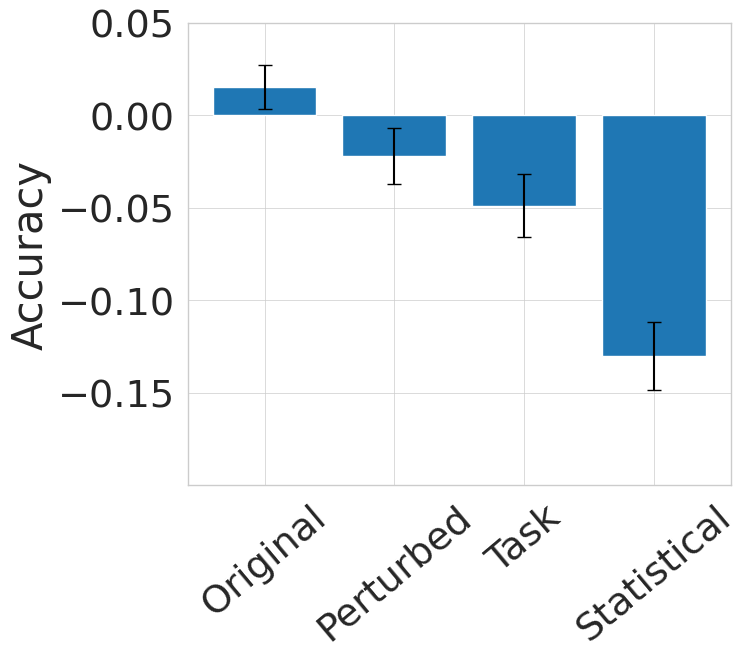

In [ ]:
plt.figure(figsize=(7, 6))
plt.bar(['Original', 'Perturbed', 'Task', 'Statistical'], [0.015394672930932284, -0.02195729501633059, -0.04877769785873718, -0.1300785927313081], yerr=[ 0.011755015331244314, 0.0149558593160509, 0.017197889286152037, 0.018572527615404996], capsize=5)

# y axis range and ticks
plt.ylim(-0.20, 0.05)
plt.yticks([-0.15, -0.1, -0.05, 0, 0.05])
plt.ylabel('Accuracy')

# rotate x axis labels by 35 degrees
plt.xticks(rotation=40)

plt.savefig('figures/gpt4-memorized.pdf', bbox_inches='tight')

### gpt-4, novel

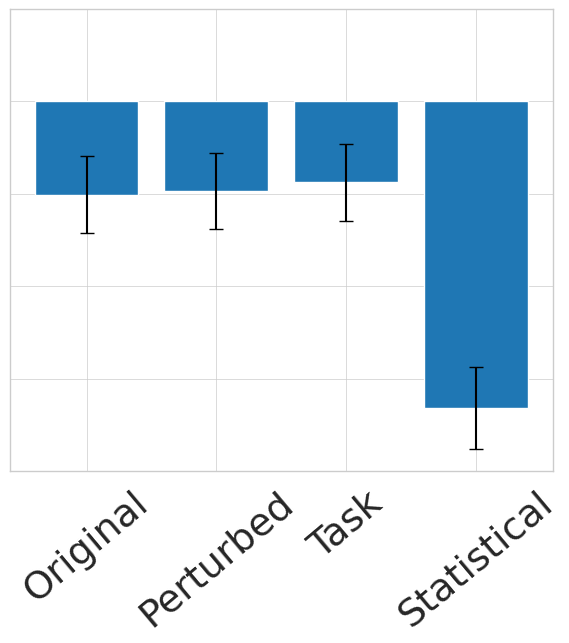

In [ ]:
fig = plt.figure(figsize=(7, 6))
ax = fig.add_subplot(111)

ax.bar(['Original', 'Perturbed', 'Task', 'Statistical'], [-0.050545098039215676, -0.048423529411764685, -0.043823529411764685 , -0.16599607843137257 ], yerr=[0.020900267559931372, 0.020754522393930535, 0.020620467546572308, 0.02220783546448782], capsize=5)

# y axis range and ticks
plt.ylim(-0.20, 0.05)
plt.yticks([-0.15, -0.1, -0.05, 0, 0.05])

# rotate x axis labels by 35 degrees
plt.xticks(rotation=40)

ax.set_yticklabels([])
ax.grid(True)

plt.savefig('figures/gpt4-novel.pdf', bbox_inches='tight')

### gpt-3.5, memorized

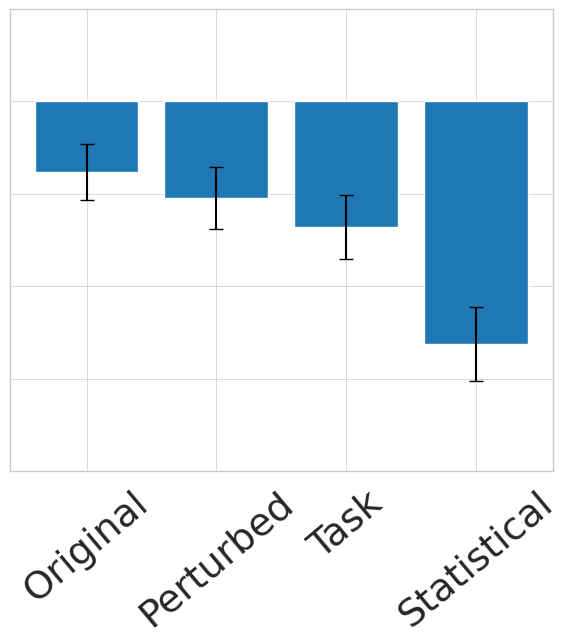

In [ ]:
plt.figure(figsize=(7, 6))
plt.bar(['Original', 'Perturbed', 'Task', 'Statistical'], [-0.03806716796029373, -0.05218806156130594, -0.06817562621638779, -0.131230238427765], yerr=[0.015299188605333908, 0.01699376849996933, 0.017320037532879074, 0.020167917603158603], capsize=5)

# y axis range and ticks
plt.ylim(-0.20, 0.05)
plt.yticks([-0.15, -0.1, -0.05, 0, 0.05])

# rotate x axis labels by 35 degrees
plt.xticks(rotation=40)

plt.gca().set_yticklabels([])
plt.gca().grid(True)

plt.savefig('figures/gpt35-memorized.pdf', bbox_inches='tight')

### gpt-3.5, novel

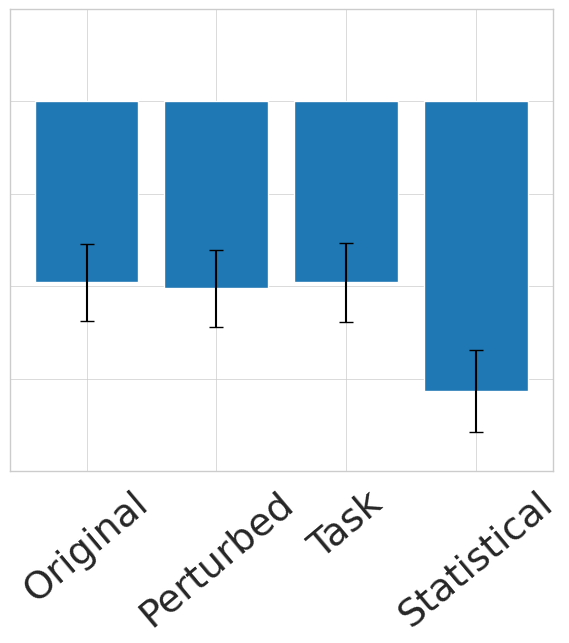

In [ ]:
plt.figure(figsize=(7, 6))
plt.bar(['Original', 'Perturbed', 'Task', 'Statistical'], [-0.0978496732026144, -0.10112941176470588, -0.09786666666666667 , -0.15668758169934643 ], yerr=[0.02098685295395071, 0.02094972636687235, 0.021255021819760953, 0.022246405174039918], capsize=5)

# y axis range and ticks
plt.ylim(-0.20, 0.05)
plt.yticks([-0.15, -0.1, -0.05, 0, 0.05])

# rotate x axis labels by 35 degrees
plt.xticks(rotation=40)

plt.gca().set_yticklabels([])
plt.gca().grid(True)

plt.savefig('figures/gpt35-novel.pdf', bbox_inches='tight')